In [1]:
import os, glob
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import seaborn as sns
import edt
from cloudvolume import CloudVolume

%matplotlib inline

In [33]:
atlas_file = '/jukebox/LightSheetTransfer/atlas/annotation_sagittal_atlas_20um_16bit_hierarch_labels.tif'
atlas_vol = np.array(tifffile.imread(atlas_file)).astype('uint16')

In [34]:
atlas_vol.dtype

dtype('uint16')

In [35]:
atlas_vol_bool = atlas_vol.astype('bool')

In [36]:
anisotropy = (20,20,20) # resolution in microns in x,y,z according to edt docs
edt_pma_bool = edt.edt(
  atlas_vol_bool,anisotropy=anisotropy, 
  black_border=True, order='C',
  parallel=6 # number of threads, <= 0 sets to num cpu
)

In [6]:
#zero out near edges
edge_microns_to_erode = 60 # min distance from edge something will be allowed
edge_mask = edt_pma_bool < edge_microns_to_erode

In [7]:
eroded_ann = atlas_vol.copy()

In [8]:
eroded_ann[edge_mask] = 0

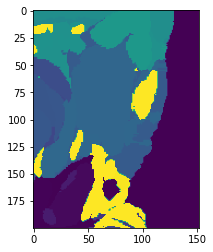

In [9]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(atlas_vol[200,200:400,200:400],vmin=0,vmax=1000)

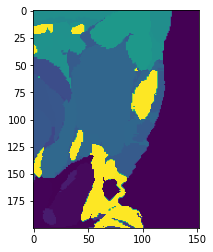

In [10]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(eroded_ann[200,200:400,200:400],vmin=0,vmax=1000)

In [ ]:
# edge erosion worked

In [11]:
#get ventricles - these are the values of ventricles in the annotation image (also the same as the look up file)
ventricle_values = [1105,1106,1109,1110,1112,1114]
ventricular_microns_to_erode = 80 # min distance from ventricle something will be allowed

In [12]:
#zero out near ventricles
# in order to do this we need a volume in which the ventricle regions are set to 0 (the reference value for the edt)
# and all other values are set to non-zero.

# First set all zero values to 1 (outside the volume either from before or from erosion in previous step)
vann = np.copy(eroded_ann)
vann[vann==0.0] = 1

In [13]:
# Now make a boolean mask finding where the ventricles are
vmask = np.isin(eroded_ann, ventricle_values)

In [14]:
# set values in vann where this mask applies to 0, the reference value for the edt
vann[vmask] = 0.0 #erode out nonventricular space adjacent to ventricles

In [15]:
# Make vann bool array so we can verify that the ventricle erosion worked
vann_bool = vann.astype('bool')

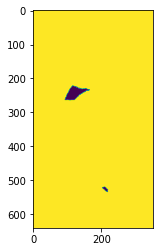

In [20]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(vann_bool[200,:,:])

In [ ]:
# looks like it worked!

In [21]:
%%time
# now calculate the edt
anisotropy = (5,5,10) # resolution in microns in x,y,z according to edt docs
edt_ventricles = edt.edt(
  vann_bool,anisotropy=anisotropy, 
  black_border=True, order='C',
  parallel=6 # number of threads, <= 0 sets to num cpu
)

CPU times: user 18.3 s, sys: 4.43 s, total: 22.7 s
Wall time: 4.48 s


In [23]:
ventricle_mask = edt_ventricles < ventricular_microns_to_erode

In [24]:
eroded_ann[ventricle_mask] = 0

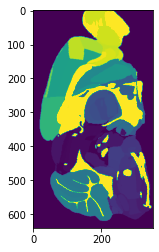

In [25]:
plt.imshow(atlas_vol[262],vmin=0,vmax=1000)

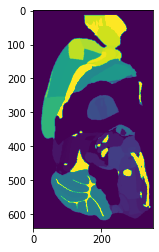

In [30]:
plt.imshow(eroded_ann[262],vmin=0,vmax=1000)

In [32]:
# Looks like it worked. Let's save the eroded volume
savename = '/jukebox/LightSheetTransfer/atlas/annotation_sagittal_atlas_20um_16bit_hierarch_labels_60um_edge_80um_vent_erosion.tif'
tifffile.imsave(savename,eroded_ann)

In [ ]:
vol = CloudVolume('file:')

In [16]:
eroded_atlas_vol.shape

(540, 640, 352)

In [17]:
eroded_atlas_vol.dtype

dtype('uint32')

In [20]:
atlas_segments = np.unique(eroded_atlas_vol)
atlas_segments = np.array([x for x in atlas_segments if x!=0])

In [51]:
2**16-1

65535

In [ ]:
# need to make a 16 bit atlas to make this faster!

In [5]:
basepath = '/jukebox/wang/Jess/lightsheet_output'
batches = ['201810_adultacutePC_ymaze_cfos',
           '201904_ymaze_cfos',
           '201908_tpham_ymaze_cfos',
           '202002_cfos',
           '202010_cfos']

In [48]:
def make_count_dict(batch,brain):
    d = os.path.join(basepath,batch,'processed',brain)
    count_dict = {'batch':batch,'brain':brain}
    cells_transformed_file = os.path.join(d,'clearmap_cluster_output/cells_transformed_to_Atlas.npy')
    if not os.path.exists(cells_transformed_file):
        cells_transformed_file = os.path.join(d,'ClearMapClusterOutput/cells_transformed_to_Atlas.npy')
    assert os.path.exists(cells_transformed_file)
    print(d)
    converted_points = np.load(cells_transformed_file)
    xyz = np.asarray([(int(xx[0]), int(xx[1]), int(xx[2])) for xx in converted_points]) #cells are counted in horizontal volumes

    # read the cells into a volume the same size as the atlas
    # init empty vol 
    cell_map = np.zeros(eroded_atlas_vol.shape).astype('uint8')
    # fill volume
    for x,y,z in xyz:
        try:
            cell_map[z,y,x] = 1 # no dilation
        except Exception as e:
            # Some cells will fall outside the volume - just how clearmap works
            print(e)
    for atlas_segment in atlas_segments[0:5]:
        atlas_mask = eroded_atlas_vol == atlas_segment
        count = len(np.nonzero(atlas_mask)[0])
        count_dict[atlas_segment] = count
    return count_dict

In [49]:
%%time
count_dict_list = [] # list of dicts which contain the batch, brain, a number of counts in each PMA region

for batch in batches[-1:]:
    batch_dir = os.path.join(basepath,batch,'processed')
    animal_dirs = glob.glob(batch_dir+'/*/')
    for d in animal_dirs[0:1]:
        brain = os.path.basename(d[:-1])
        count_dict = make_count_dict(batch,brain)
        print(count_dict)

/jukebox/wang/Jess/lightsheet_output/202010_cfos/processed/an024
{'batch': '202010_cfos', 'brain': 'an024', 1: 12571, 2: 9621, 4: 4820, 6: 176678, 7: 77756}
CPU times: user 3.34 s, sys: 524 ms, total: 3.86 s
Wall time: 3.87 s


In [42]:
count_dict

{'batch': '202010_cfos', 'brain': 'an024', 1: 12571}

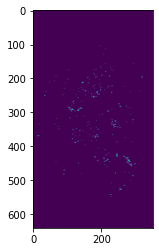

In [9]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.imshow(cell_map[150])

In [21]:
atlas_mask = eroded_atlas_vol == atlas_segments[1]

In [4]:
cat /jukebox/wang/ahoag/for_jess


#! /bin/env python

import os, sys
import glob
import numpy as np

from cloudvolume.lib import mkdir, touch
from cloudvolume import CloudVolume

import logging
import argparse
import struct
import json

import edt

def make_info_file(volume_size,resolution,layer_dir):
    """ 
    ---PURPOSE---
    Make the precomputed annotation info file.
    ---INPUT---
    volume_size     [Nx,Ny,Nz] in voxels, e.g. [2160,2560,1271]
    resolution      [size of x pix in nm,size of y pix in nm,size of z pix in nm], e.g. [5000,5000,10000]
    commit          if True, will write the info/provenance file to disk. 
                    if False, just creates it in memory
    """
    x_nm, y_nm, z_nm = resolution
    x_m = x_nm*1e-09
    y_m = y_nm*1e-09
    z_m = z_nm*1e-09

    Nx,Ny,Nz = volume_size
    info_dict = {"@type" : "neuroglancer_annotations_v1",
        "annotation_type" : "POINT",
        "by_id" : {
            "key" : "by_id"
            },
        "dimensions" : {
            "x" : [ "{0: